## 2024 Open Science Data Challenge - Landsat with Cloud Filtering

This notebook  demonstrates extracting images from Landsat data which has 30m resolution with cloud filtering. This pixel-based approach is better than a scene-based approach since clouds are quite random for any given time and location.The results of this notebook can be employed to enhance the comprehension of the data or to generate additional training data. This can aid in the development of a machine learning model capable of detecting damaged and undamaged infrastructure. The baseline data is [Landsat Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data from the Microsoft Planetary Computer catalog. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio


# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load


# Pass your API key here
pc.settings.set_subscription_key('********************************')


### Load the satellite data

To load the satellite data, we define our area of interest using a bounding box. Bounding box needs to be defined in a specific format : (min longitude, min latitude, max longitude, max latitude), so be careful when entering the coordinates. Finally, we define the time window consistent in which natural disaster occured.

In [2]:
# Defining the Region of Interest
bounds = (-66.1938588694226,18.27471974898704,-66.08007533079798,18.478571816747003)

In [3]:
# Define the time window
time_window="2017-08-01/2017-11-30"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. To avoid issues with Landsat-7 data, we have only included data from Landsat-8 and Landsat-9 missions.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 23


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The [ODC](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands, including the "qa_pixel" cloud filtering band, reproject into Lat-Lon coordinates (EPSG:4326) at 30-meters resolution (typical of Landsat pixel resolution), and clip the region to the spatial bounding box. 

In [5]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [6]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

In [7]:
# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

In [8]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 757, longitude: 423, time: 23)
Coordinates:
  * latitude     (latitude) float64 18.48 18.48 18.48 ... 18.28 18.28 18.27
  * longitude    (longitude) float64 -66.19 -66.19 -66.19 ... -66.08 -66.08
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2017-08-09T14:44:03.584741 ... 2017-11...
Data variables:
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 757, 423), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 757, 423), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 757, 423), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 dask.array<chunksize=(1, 757, 423), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 dask.array<chunksize=(1, 757, 423), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available for Landsat-8 from April-2013 to now. Data is available for Landsat-9 from Feb-2022 to now. So, for the selected time window and missions there are typically views of our region every 8 days. But, due to scene overlaps, there are few more scenes within those 8-day increments. For this example over 3 months, there are 23 time slices that touch our region. Unfortunately, there are only few clear scenes and several other partially cloudy scenes. 

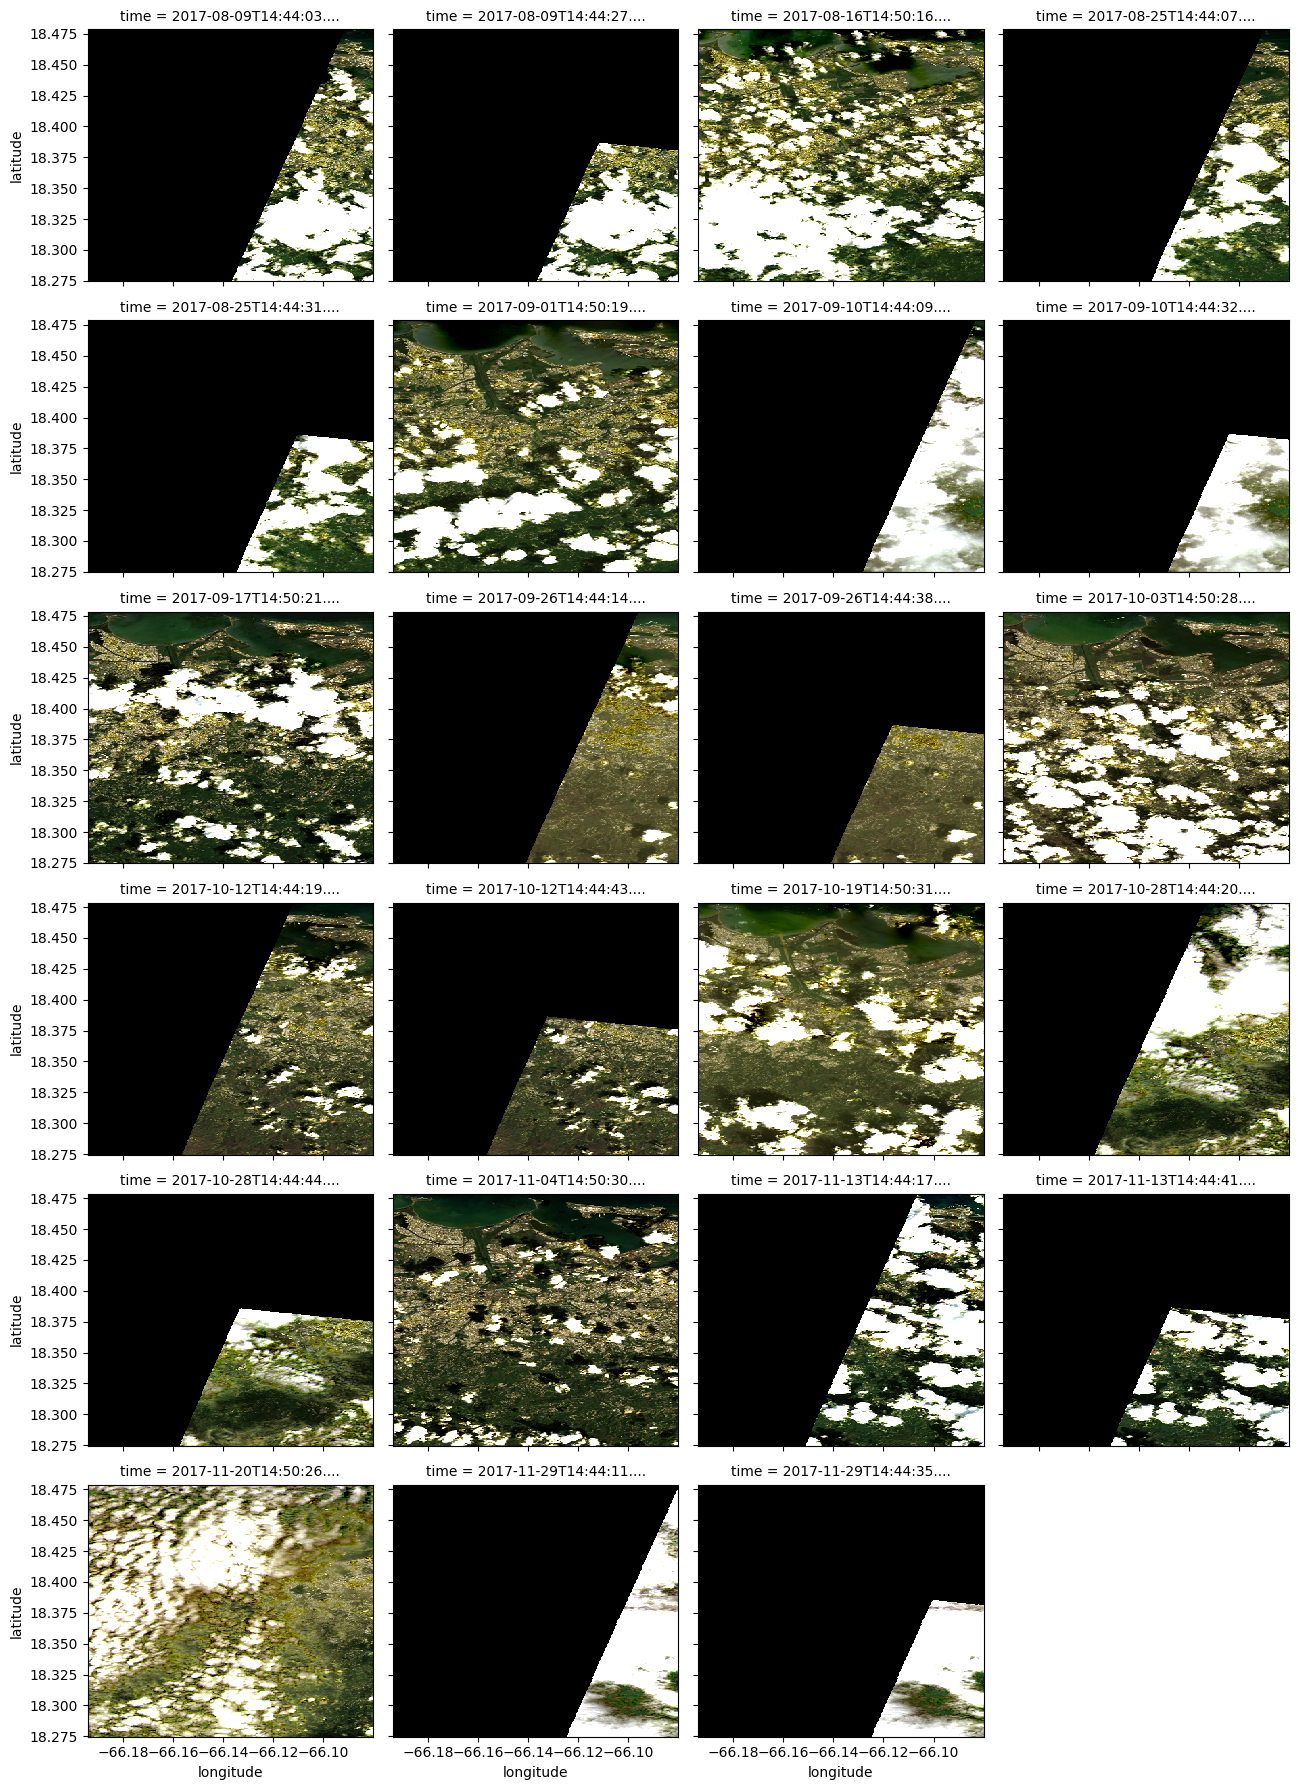

In [9]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

In [10]:
# Select a time slice to view a simple RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

# Slice #10 - Mostly Clear
# Slice #17 - Scattered Clouds
# Slice # - Very Cloudy

time_slice = 17

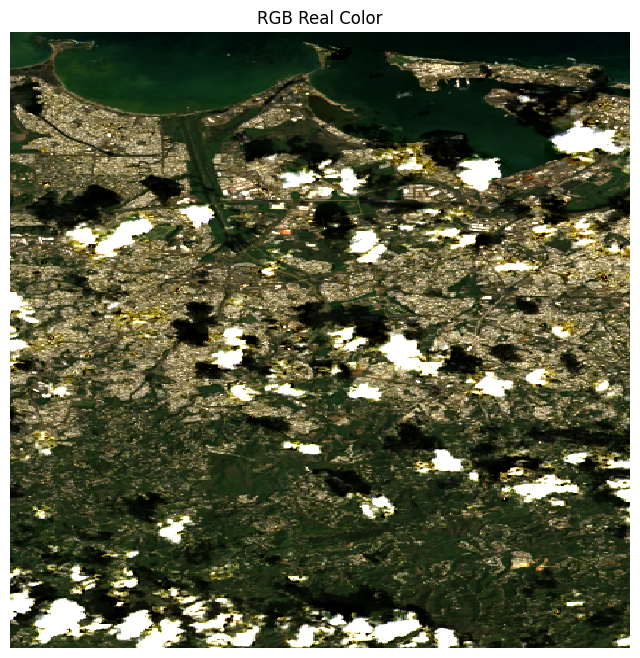

In [11]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

Cloud masking for Landsat Collection-2 Level-2 data can be complicated. The <b>"qa_pixel"</b> band is used to assess each pixel and determine its cloud or water classification. The code below is credited to Mauricio Cordiero. See his webpage [HERE](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for a more detailed explanation of the process. Also, you can visit the Landsat-8 Collection-2 Level-2 Product Guide [HERE](https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide) for more details about the cloud mask values. In the end, we are searching for clouds, cloud shadows, and water to create a mask for any given region. This will allow us to extract the "clear" pixels to assess the vegetation state. 

In [12]:
# To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
# See the website above for a nice explanation of the process

bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7
}

In [13]:
# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):
    
    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # Loop through the flags  
    for flag in flags_list:
        
        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [14]:
# Pick a single time slice to view a mask with clouds and water
sample_xx = xx.isel(time=time_slice)

In [15]:
# Find the pixels that are no data (fill), clouds, cloud shadows, or water
my_mask = get_mask(sample_xx['qa_pixel'],
                   ['fill', 'dilated_cloud', 'cirrus', 
                    'cloud', 'shadow', 'water'])

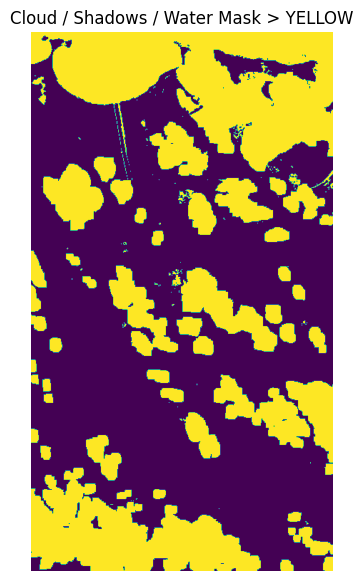

In [16]:
# Show only the mask (Yellow) with valid data in Purple
plt.figure(figsize=(7,7))
plt.imshow(my_mask)
plt.title("Cloud / Shadows / Water Mask > YELLOW")
plt.axis('off')
plt.show()

In [17]:
# Create an RGB function that will display the mask over the background RGB image

def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb

In [18]:
rgb = plot_masked_rgb(sample_xx['red'], sample_xx['green'], sample_xx['blue'], my_mask, color_mask=(1, 0, 1), transparency=0.2, brightness=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


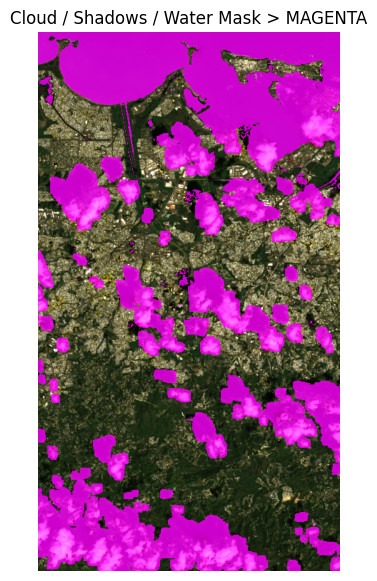

In [19]:
# This is a nice image that shows the clouds and water pixels (Purple) among clear land pixels
plt.figure(figsize=(7,7))
plt.imshow(rgb)
plt.title("Cloud / Shadows / Water Mask > MAGENTA")
plt.axis('off')
plt.show()